In [1]:
import sympy as sm
from sympy import diff, Symbol, cos
from scipy.integrate import solve_ivp,OdeSolver,odeint
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [3]:
m1, m2, l1, l2, gty ,tau1, tau2, c1, c2, L, I1, I2 = sm.symbols('m1 m2 l1 l2 g tau1 tau2 c1 c2 L I1 I2', real =True)
t = Symbol('t')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2,I1, I2

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2, I1, I2)

In [4]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)

x1_dot = sm.diff(x1,t)
x2_dot = sm.diff(x2,t)
y1_dot = sm.diff(y1,t)
y2_dot = sm.diff(y2,t)

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*sin(theta2)*theta2', l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')

# dynamic modeling on manipulator without constraint using lagrange equation

In [5]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [6]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta2)

In [7]:
# the lagrangian equation
Ls = ke - pe

In [8]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),t) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + l1**2*m1*theta1'' + l1**2*m2*theta1'' + l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + l1*l2*m2*cos(theta1 - theta2)*theta2''

In [9]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),t) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta2) - l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + l1*l2*m2*cos(theta1 - theta2)*theta1'' + l2**2*m2*theta2''

In [10]:
#inertia term
it11 = f1sim.coeff(theta1dd) * theta1dd
it12 = f2sim.coeff(theta1dd) * theta1dd

it21 = f1sim.coeff(theta2dd) * theta2dd
it22 = f2sim.coeff(theta2dd) * theta2dd

m11 = f1sim.coeff(theta1dd)
m12 = f2sim.coeff(theta1dd)

m21 = f1sim.coeff(theta2dd)
m22 = f2sim.coeff(theta2dd)

M = sm.Matrix([[m11, m21], [m12, m22]])
M

Matrix([
[          l1**2*m1 + l1**2*m2, l1*l2*m2*cos(theta1 - theta2)],
[l1*l2*m2*cos(theta1 - theta2),                      l2**2*m2]])

In [11]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([[C11], [C12]])
C

Matrix([
[ l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [12]:
# gravity term
g1 = f1sim - sm.expand(it11) - sm.expand(it21) - sm.expand(C11)
g2 = f2sim - sm.expand(it12) - sm.expand(it22) - sm.expand(C12)
G = sm.Matrix([g1, g2])
G

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1)],
[                      g*l2*m2*cos(theta2)]])

In [13]:
tau = sm.Matrix([[tau1], [tau2]])
tau

Matrix([
[tau1],
[tau2]])

In [14]:
F = tau -C -G
F

Matrix([
[-g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + tau1],
[                      -g*l2*m2*cos(theta2) + l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + tau2]])

# Dynamic modeling subject to constraint

In [15]:
endefX = x2 - L #endeffector x trajectory
endefY = y2 - 0.2*(1-sm.cos(t)) #endeffector y trajectory
endefX, endefY

(-L + l1*cos(theta1) + l2*cos(theta2), l1*sin(theta1) + l2*sin(theta2) + 0.2*cos(t) - 0.2)

In [16]:
# get second order form
endefXdd = sm.diff(sm.diff(endefX,t),t)
endefYdd = sm.diff(sm.diff(endefY,t),t)
endefXdd, endefYdd

(-l1*sin(theta1)*theta1'' - l1*cos(theta1)*theta1'**2 - l2*sin(theta2)*theta2'' - l2*cos(theta2)*theta2'**2, -l1*sin(theta1)*theta1'**2 + l1*cos(theta1)*theta1'' - l2*sin(theta2)*theta2'**2 + l2*cos(theta2)*theta2'' - 0.2*cos(t))

In [17]:
A11 = endefXdd.coeff(theta1dd)
A21 = endefXdd.coeff(theta2dd)

A12 = endefYdd.coeff(theta1dd)
A22 = endefYdd.coeff(theta2dd)

A = sm.Matrix([[A11, A21], [A12, A22]])
A

Matrix([
[-l1*sin(theta1), -l2*sin(theta2)],
[ l1*cos(theta1),  l2*cos(theta2)]])

In [18]:
b1 = endefXdd - sm.expand(A11)*theta1dd - sm.expand(A21)*theta2dd
b2 = endefYdd - sm.expand(A12)*theta1dd - sm.expand(A22)*theta2dd
b = -sm.Matrix([b1,b2])
b

Matrix([
[             l1*cos(theta1)*theta1'**2 + l2*cos(theta2)*theta2'**2],
[l1*sin(theta1)*theta1'**2 + l2*sin(theta2)*theta2'**2 + 0.2*cos(t)]])

# calculating constraints force

In [30]:
# ode func for scipy solve_ivp
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

t_span = (0, 100)
g_ = 0
m1_ = 1
m2_ = 1
l1_ = 1
l2_ = 1
tq1_ = 0
tq2_ = 0
c1_ = 0
c2_ = 0
y0 = [30,0,-30,0]  # Initial state of the system


In [31]:
h_sn = (A*(M**(-1/2))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
j_sn = (M**(1/2)).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
k_sn = (b-(A*(M.inv()*F))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
F_sn = F.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
M_sn = M.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})

In [32]:
def dSdt(t,S, gt, m1, m2, l1, l2,c1, c2, torq1, torq2):
    thet1_, dtheta1_, thet2_, dtheta2_ = S
    
    print(t, S)
    
    h_n = h_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    j_n = j_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    k_n = k_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    psu_i = h_n.pinv()
    Fc = (j_n * psu_i * k_n)
    F_n = F_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    rf = F_n + Fc
    ra = M_sn.inv().subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf() * rf
    return [
        theta1d_func(dtheta1_),
        ra[0],
        theta2d_func(dtheta2_),
        ra[1]
    ]

In [40]:
solve_ivp_rk45 = solve_ivp(dSdt,t_span, y0, method="LSODA", args = (g_,m1_,m2_,l1_,l2_,c1_,c2_,tq1_,tq2_))

0.0 [ 30.   0. -30.   0.]
4.8778591397005856e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227766e-05]
4.8778591397005856e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227766e-05]
9.755718279401171e-05 [ 3.00000000e+01  6.32455532e-05 -3.00000000e+01  6.32455531e-05]
9.755718279401171e-05 [ 3.00000000e+01  6.32455531e-05 -3.00000000e+01  6.32455529e-05]
0.00028692353341082367 [ 3.00000000e+01  1.86010266e-04 -3.00000000e+01  1.86010265e-04]
0.00028692353341082367 [ 3.00000000e+01  1.86010265e-04 -3.00000000e+01  1.86010263e-04]
0.0004762898840276356 [ 3.00000001e+01  3.08774973e-04 -2.99999999e+01  3.08774967e-04]
0.0004762898840276356 [ 3.00000001e+01  3.08774972e-04 -2.99999999e+01  3.08774964e-04]
0.0006656562346444476 [ 3.00000001e+01  4.31539672e-04 -2.99999999e+01  4.31539654e-04]
0.0006656562346444476 [ 3.00000001e+01  4.31539671e-04 -2.99999999e+01  4.31539651e-04]
0.0008550225852612596 [ 3.00000002e+01  5.54304361e-04 -2.99999998e+01  5.54304320e-04]
0.

2.2732543628373523 [ 30.89190676   0.28969082 -29.25307238   0.17531837]
2.4274036410933175 [ 30.93274883   0.23575545 -29.2288996    0.13421433]
2.5815529193492828 [ 30.96520078   0.18354368 -29.21080511   0.09916017]
2.5503358096777555 [ 30.95916617   0.19422329 -29.21417471   0.10614169]
2.6732679782621935 [ 30.9804447    0.1533427  -29.20278285   0.08099465]
2.7962001468466315 [ 30.99673515   0.11291705 -29.19434021   0.05808075]
2.9191323154310695 [ 31.00814773   0.07283101 -29.18852368   0.03681749]
3.0420644840155076 [ 3.10146692e+01  3.29631310e-02 -2.91852208e+01  1.66456404e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150270e+01 -2.95853762e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853758e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849494e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849499e+01 -

11.565139908320406 [ 30.30374106  -0.52948735 -29.70700751  -0.4790636 ]
11.565139908320406 [ 30.30374106  -0.52948736 -29.70700706  -0.4790636 ]
11.565139908320406 [ 30.30374106  -0.52948736 -29.70700751  -0.47906359]
11.627430514466365 [ 30.27122833  -0.51374793 -29.73660017  -0.47030322]
11.689721120612324 [ 30.23980682  -0.49446746 -29.76552331  -0.45762918]
11.752011726758283 [ 30.20969133  -0.4718351  -29.79353704  -0.44114319]
11.914739486115325 [ 30.13870405  -0.3984255  -29.8607077   -0.38103875]
11.914739486115325 [ 30.1387045   -0.3984255  -29.8607077   -0.38103875]
11.914739486115325 [ 30.13870405  -0.39842549 -29.8607077   -0.38103875]
11.914739486115325 [ 30.13870405  -0.3984255  -29.86070725  -0.38103875]
11.914739486115325 [ 30.13870405  -0.3984255  -29.8607077   -0.38103874]
11.914739486115325 [ 30.13853951  -0.39883192 -29.86083753  -0.38161721]
12.077467245472366 [ 30.0808778   -0.31071132 -29.9164659   -0.30257497]
12.077467245472366 [ 30.08066582  -0.30981786 -29.9

15.836761115369024 [ 3.10229040e+01 -4.03347607e-02 -2.91757830e+01 -1.93271804e-02]
15.836761115369024 [ 3.10229044e+01 -4.03347607e-02 -2.91757830e+01 -1.93271804e-02]
15.836761115369024 [ 3.10229040e+01 -4.03347601e-02 -2.91757830e+01 -1.93271804e-02]
15.836761115369024 [ 3.10229040e+01 -4.03347607e-02 -2.91757825e+01 -1.93271804e-02]
15.836761115369024 [ 3.10229040e+01 -4.03347607e-02 -2.91757830e+01 -1.93271801e-02]
15.871733433250906 [ 3.10212966e+01 -5.15910203e-02 -2.91765562e+01 -2.49066406e-02]
15.906705751132789 [ 3.10192953e+01 -6.28624582e-02 -2.91775257e+01 -3.05535597e-02]
15.94167806901467 [ 31.01689947  -0.07415257 -29.17869423  -0.03628258]
16.104189965065782 [ 31.00057307  -0.1269602  -29.18680989  -0.06440347]
16.104189965065782 [ 31.00057353  -0.1269602  -29.18680989  -0.06440347]
16.104189965065782 [ 31.00057307  -0.1269602  -29.18680989  -0.06440347]
16.104189965065782 [ 31.00057307  -0.1269602  -29.18680945  -0.06440347]
16.104189965065782 [ 31.00057307  -0.1269

21.92610361083233 [ 3.10309239e+01  2.13976243e-02 -2.91684118e+01  1.04959414e-02]
21.92610361083233 [ 3.10308994e+01  2.13492113e-02 -2.91685168e+01  1.04201917e-02]
22.060452236222766 [ 3.10309038e+01 -2.15914911e-02 -2.91684226e+01 -1.02474654e-02]
22.1948008616132 [ 31.02510598  -0.06464383 -29.17123815  -0.03137862]
22.329149487003633 [ 31.0135073   -0.10797865 -29.17696668  -0.05374926]
22.463498112394067 [ 30.9960571   -0.1517905  -29.18582828  -0.07816608]
22.641761136611702 [ 30.96375959  -0.21094603 -29.20290246  -0.11502348]
22.641761136611702 [ 30.96376005  -0.21094603 -29.20290246  -0.11502348]
22.641761136611702 [ 30.96375959  -0.21094603 -29.20290246  -0.11502348]
22.641761136611702 [ 30.96375959  -0.21094603 -29.20290203  -0.11502348]
22.641761136611702 [ 30.96375959  -0.21094603 -29.20290246  -0.11502348]
22.641761136611702 [ 30.96371423  -0.21087049 -29.20311604  -0.11487738]
22.820024160829337 [ 30.92079522  -0.27140356 -29.227138    -0.15819453]
22.820024160829337 

28.291154210583553 [ 3.10410112e+01 -3.96808160e-03 -2.91585601e+01 -1.52429265e-03]
28.291154210583553 [ 3.10410117e+01 -3.96808160e-03 -2.91585601e+01 -1.52429265e-03]
28.291154210583553 [ 3.10410112e+01 -3.96808154e-03 -2.91585601e+01 -1.52429265e-03]
28.291154210583553 [ 3.10410112e+01 -3.96808160e-03 -2.91585597e+01 -1.52429265e-03]
28.291154210583553 [ 3.10410112e+01 -3.96808160e-03 -2.91585601e+01 -1.52429263e-03]
28.291154210583553 [ 3.10410114e+01 -3.96975752e-03 -2.91585596e+01 -1.53124709e-03]
28.3152950733915 [ 3.10408231e+01 -1.16272834e-02 -2.91586404e+01 -5.15580556e-03]
28.3152950733915 [ 3.10408231e+01 -1.16286490e-02 -2.91586404e+01 -5.16139425e-03]
28.339435936199447 [ 3.10404499e+01 -1.92874585e-02 -2.91588088e+01 -8.79351473e-03]
28.385922022598177 [ 3.10392104e+01 -3.40438251e-02 -2.91593807e+01 -1.58286598e-02]
28.385922022598177 [ 3.10392109e+01 -3.40438251e-02 -2.91593807e+01 -1.58286598e-02]
28.385922022598177 [ 3.10392104e+01 -3.40438246e-02 -2.91593807e+01 -

32.32664280076779 [ 30.28509311   0.51655343 -29.71404878   0.47181748]
32.484882043038496 [ 30.37042114   0.55024799 -29.63731389   0.48642381]
32.484882043038496 [ 30.36977558   0.55161105 -29.63784167   0.48847645]
32.45614690051549 [ 30.35444715   0.54618934 -29.65149036   0.48604604]
32.58565100026319 [ 30.42618628   0.5596126  -29.58848768   0.48383747]
32.71515510001089 [ 30.49869543   0.55732655 -29.52676135   0.46625607]
32.84465919975859 [ 30.57006935   0.54148045 -29.46806947   0.43649215]
32.97416329950629 [ 30.63867514   0.51475034 -29.41381263   0.39814053]
33.103667399253986 [ 30.70326654   0.48000899 -29.36489544   0.35478517]
33.233171499001685 [ 30.76296866   0.43992257 -29.3217701    0.30957476]
33.37654992321156 [ 30.82262189   0.39208466 -29.28096541   0.26050075]
33.51992834742144 [ 30.87532656   0.3425823  -29.24694602   0.21437237]
33.49193501042172 [ 30.86574499   0.35199901 -29.25290694   0.22266203]
33.60732009763188 [ 30.90408758   0.31194044 -29.22922013   

36.68132661159229 [ 30.3521226   -0.53749663 -29.65220873  -0.47851219]
36.68132661159229 [ 30.35268539  -0.53888792 -29.65139853  -0.47965588]
36.85016615152372 [ 30.26470329  -0.49157022 -29.73127786  -0.45143128]
36.80626557173352 [ 30.28692766  -0.50709804 -29.71078931  -0.46222932]
36.80626557173352 [ 30.28692811  -0.50709804 -29.71078931  -0.46222932]
36.80626557173352 [ 30.28692766  -0.50709803 -29.71078931  -0.46222932]
36.80626557173352 [ 30.28692766  -0.50709804 -29.71078887  -0.46222932]
36.80626557173352 [ 30.28692766  -0.50709804 -29.71078931  -0.46222931]
36.80626557173352 [ 30.28718851  -0.50847995 -29.71036993  -0.46356824]
36.93120453187475 [ 30.22629442  -0.46204441 -29.76656561  -0.42983406]
36.93120453187475 [ 30.22632234  -0.46339482 -29.76641703  -0.43129524]
37.05614349201598 [ 30.17203176  -0.40432644 -29.81745747  -0.38269098]
37.181082452157206 [ 30.12559321  -0.33649579 -29.86172062  -0.32308832]
37.306021412298435 [ 30.08811569  -0.26107168 -29.89791266  -0.

40.93518483325678 [ 3.10560527e+01 -2.87374063e-02 -2.91468301e+01 -1.36637185e-02]
40.93518483325678 [ 3.10560526e+01 -2.87384857e-02 -2.91468304e+01 -1.36683107e-02]
40.97222435678024 [ 3.10547742e+01 -4.03010977e-02 -2.91474356e+01 -1.90391618e-02]
41.0092638803037 [ 3.10530671e+01 -5.18759189e-02 -2.91482411e+01 -2.44674893e-02]
41.04630340382716 [ 3.10509310e+01 -6.34672218e-02 -2.91492491e+01 -2.99714655e-02]
41.141533986461575 [ 31.04346555  -0.09337489 -29.15278833  -0.0445981 ]
41.141533986461575 [ 31.04346602  -0.09337489 -29.15278833  -0.0445981 ]
41.141533986461575 [ 31.04346555  -0.09337489 -29.15278833  -0.0445981 ]
41.141533986461575 [ 31.04346555  -0.09337489 -29.1527879   -0.0445981 ]
41.141533986461575 [ 31.04346555  -0.09337489 -29.15278833  -0.0445981 ]
41.23676456909599 [ 31.03314301  -0.12348497 -29.15776042  -0.06012539]
41.3319951517304 [ 31.01993943  -0.15385936 -29.16427162  -0.07682691]
41.42722573436482 [ 31.00382766  -0.18455099 -29.17244349  -0.09495597]
4

45.54548223193489 [ 30.66087014   0.50373408 -29.39656552   0.38298606]
45.696075940245585 [ 30.73373319   0.46239088 -29.34264396   0.33244124]
45.84666964855628 [ 30.79981567   0.41470824 -29.29653589   0.28042472]
45.99726335686697 [ 30.85845331   0.36407779 -29.25813848   0.2306115 ]
46.14785706517767 [ 30.90939271   0.31280675 -29.22692668   0.18525502]
46.29845077348836 [ 30.95264423   0.26214325 -29.20214351   0.14529016]
46.449044481799056 [ 30.98834604   0.21253527 -29.18296706   0.1106633 ]
46.61745465682551 [ 31.01955779   0.1582044  -29.16719514   0.07735957]
46.78586483185196 [ 31.04162255   0.10522079 -29.15674059   0.04901413]
46.95427500687841 [ 3.10548146e+01  5.27891484e-02 -2.91507930e+01  2.36080357e-02]
46.95427500687841 [ 3.10549574e+01  5.23866626e-02 -2.91506173e+01  2.31319051e-02]
46.916061175160806 [ 3.10526433e+01  6.45249698e-02 -2.91517128e+01  2.90352214e-02]
47.04625751846965 [ 3.10584206e+01  2.39205476e-02 -2.91491517e+01  1.00329176e-02]
47.1764538617

56.487610076447616 [ 30.07145278  -0.03885554 -29.9225678   -0.03873369]
56.487610076447616 [ 30.07145278  -0.03885554 -29.92256735  -0.03873369]
56.487610076447616 [ 30.07145278  -0.03885554 -29.9225678   -0.03873369]
56.487610076447616 [ 30.0715509   -0.03927018 -29.92245884  -0.03908428]
56.613142409704835 [ 30.07194244   0.04457191 -29.92217944   0.04287225]
56.613142409704835 [ 30.07185329   0.04432974 -29.92225042   0.04261545]
56.59662236574634 [ 30.07127682   0.03351647 -29.92281389   0.03206858]
56.70563465504507 [ 30.07883687   0.10559726 -29.91550034   0.10229258]
56.81464694434379 [ 30.09417947   0.17641438 -29.90064764   0.17052176]
56.92365923364252 [ 30.1171373    0.24481106 -29.87852035   0.23521065]
57.03267152294124 [ 30.14738084   0.3094487  -29.84958799   0.29469324]
57.194081872773694 [ 30.204458     0.39502598 -29.79572085   0.36947657]
57.194081872773694 [ 30.20445845   0.39502598 -29.79572085   0.36947657]
57.194081872773694 [ 30.204458     0.39502599 -29.795720

63.15579177637543 [ 30.11490564   0.20914106 -29.88572068   0.20094462]
63.15579177637543 [ 30.11490519   0.20914106 -29.88572068   0.20094462]
63.15579177637543 [ 30.11490519   0.20914106 -29.88572024   0.20094462]
63.15579177637543 [ 30.11490519   0.20914106 -29.88572068   0.20094462]
63.15579177637543 [ 30.11486138   0.20907689 -29.88578124   0.20090399]
63.279491245020814 [ 30.14544098   0.28315083 -29.85648303   0.26967059]
63.4031907136662 [ 30.18472654   0.35107104 -29.81928532   0.33028598]
63.52689018231158 [ 30.23187668   0.41057074 -29.77526869   0.38032262]
63.688087931724674 [ 30.30339571   0.47185383 -29.70980517   0.42606876]
63.688087931724674 [ 30.30339616   0.47185383 -29.70980517   0.42606876]
63.688087931724674 [ 30.30339571   0.47185383 -29.70980517   0.42606876]
63.688087931724674 [ 30.30339571   0.47185383 -29.70980473   0.42606876]
63.688087931724674 [ 30.30339571   0.47185383 -29.70980517   0.42606877]
63.688087931724674 [ 30.30284086   0.47197243 -29.71035959 

69.39372984736077 [ 30.11305512   0.18007466 -29.8881675    0.17379278]
69.51851133233373 [ 30.14040554   0.25630333 -29.8618452    0.24519032]
69.64329281730669 [ 30.17686169   0.32709426 -29.82716496   0.30923398]
69.76807430227964 [ 30.22164956   0.39014872 -29.78513912   0.36338444]
69.9252356745627 [ 30.28836014   0.45499542 -29.72369753   0.41388677]
70.08239704684576 [ 30.36328754   0.49926241 -29.65657931   0.44153732]
70.08239704684576 [ 30.3633228    0.50031933 -29.65643235   0.442649  ]
70.23955841912881 [ 30.44378667   0.52228416 -29.58659295   0.44640223]
70.39671979141187 [ 30.52644781   0.52448608 -29.51727247   0.43063977]
70.55388116369492 [ 30.60802461   0.50804797 -29.45172703   0.39800092]
70.74290113244417 [ 30.7005887    0.4696548  -29.38143846   0.34505857]
70.74290113244417 [ 30.70058916   0.4696548  -29.38143846   0.34505857]
70.74290113244417 [ 30.7005887    0.46965481 -29.38143846   0.34505857]
70.74290113244417 [ 30.7005887    0.4696548  -29.38143803   0.345

76.04442424578838 [ 30.2234556    0.38720479 -29.78335646   0.36052527]
76.22225202428359 [ 30.29921227   0.45948792 -29.71381874   0.41632636]
76.22225202428359 [ 30.29912179   0.46011257 -29.71379221   0.41717133]
76.4000798027788 [ 30.38555208   0.50572044 -29.63684787   0.44302571]
76.57790758127402 [ 30.47766651   0.52424188 -29.55769051   0.44088783]
76.75573535976923 [ 30.57075046   0.51723854 -29.48117808   0.41436338]
76.93356313826445 [ 30.66062017   0.48936845 -29.41109831   0.37036829]
77.11139091675966 [ 30.74404589   0.44630641 -29.3499021    0.31643927]
77.07463954929347 [ 30.7277176    0.45559985 -29.36148812   0.3272534 ]
77.21571596032248 [ 30.78927071   0.41534216 -29.31848215   0.28189762]
77.3567923713515 [ 30.84486495   0.37171294 -29.28180692   0.23758463]
77.49786878238052 [ 30.89407408   0.32651465 -29.25131243   0.1961818 ]
77.63894519340954 [ 30.93687913   0.28104304 -29.22638603   0.15876321]
77.80253116806527 [ 30.97857498   0.22865903 -29.203593     0.1205

83.85382932183887 [ 30.92427071   0.30131731 -29.23309807   0.17415183]
83.97703775707696 [ 30.95897363   0.26219283 -29.2135518    0.14374171]
84.12397583903036 [ 30.99409871   0.21580012 -29.19483349   0.11145131]
84.27091392098377 [ 31.02243879   0.16991564 -29.18056754   0.08320866]
84.41785200293718 [ 31.0440731    0.1245799  -29.17019825   0.05842808]
84.56479008489059 [ 31.05907194   0.07973815 -29.16327463   0.03635122]
84.56479008489059 [ 31.05904324   0.0798417  -29.16331743   0.03648257]
84.711728166844 [ 3.10675141e+01  3.52313759e-02 -2.91594436e+01  1.60545255e-02]
84.8586662487974 [ 3.10694219e+01 -9.11642296e-03 -2.91585356e+01 -3.46767868e-03]
85.00560433075081 [ 3.10648260e+01 -5.34898398e-02 -2.91604836e+01 -2.31942778e-02]
84.97458855144869 [ 3.10663393e+01 -4.41062531e-02 -2.91598319e+01 -1.89483943e-02]
85.09051085409997 [ 31.05919424  -0.07920705 -29.16295335  -0.03506474]
85.20643315675126 [ 31.04796941  -0.1144793  -29.1680038   -0.05226692]
85.32235545940254 [

91.16841950806159 [ 3.10804797e+01 -1.60862376e-02 -2.91492549e+01 -5.74219083e-03]
91.13934531865988 [ 3.10808181e+01 -7.39045016e-03 -2.91491505e+01 -1.98941306e-03]
91.27904301434229 [ 3.10768740e+01 -4.90949065e-02 -2.91506847e+01 -2.00485219e-02]
91.24618845041118 [ 3.10783249e+01 -3.92713903e-02 -2.91500996e+01 -1.57268484e-02]
91.24618845041118 [ 3.10783254e+01 -3.92713903e-02 -2.91500996e+01 -1.57268484e-02]
91.24618845041118 [ 3.10783249e+01 -3.92713897e-02 -2.91500996e+01 -1.57268484e-02]
91.24618845041118 [ 3.10783249e+01 -3.92713903e-02 -2.91500992e+01 -1.57268484e-02]
91.24618845041118 [ 3.10783249e+01 -3.92713903e-02 -2.91500996e+01 -1.57268482e-02]
91.24618845041118 [ 3.10783240e+01 -3.92695754e-02 -2.91501023e+01 -1.57170256e-02]
91.35303158216249 [ 3.10724205e+01 -7.12432226e-02 -2.91525381e+01 -2.99655473e-02]
91.45987471391379 [ 31.06309667  -0.10333154 -29.1565342   -0.04503402]
91.5667178456651 [ 31.05033464  -0.13560206 -29.16220109  -0.06128979]
91.6735609774164 

99.32931151819052 [ 30.55128657  -0.51270955 -29.48289901  -0.41585975]
99.50967685067252 [ 30.45932758  -0.50225714 -29.55924067  -0.426334  ]
99.69004218315452 [ 30.37174009  -0.46315091 -29.63500159  -0.40780128]
99.69004218315452 [ 30.3716893   -0.46313681 -29.63506664  -0.40781351]
99.54574991716892 [ 30.44134858  -0.49840751 -29.57443857  -0.42682959]
99.54574991716892 [ 30.44134903  -0.49840751 -29.57443857  -0.42682959]
99.54574991716892 [ 30.44134858  -0.4984075  -29.57443857  -0.42682959]
99.54574991716892 [ 30.44134858  -0.49840751 -29.57443813  -0.42682959]
99.54574991716892 [ 30.44134858  -0.49840751 -29.57443857  -0.42682958]
99.58182298366532 [ 30.42348335  -0.49181959 -29.58979624  -0.42448637]
99.61789605016172 [ 30.40587825  -0.48401553 -29.60504753  -0.42085096]
99.65396911665812 [ 30.38857701  -0.47500094 -29.62014467  -0.41593743]
99.72611524965092 [ 30.35505828  -0.45342034 -29.64969286  -0.40227251]
99.72611524965092 [ 30.35505874  -0.45342034 -29.64969286  -0.40

In [41]:
t = solve_ivp_rk45.t
the1 = solve_ivp_rk45.y[0]
the1d = solve_ivp_rk45.y[1]
the2 = solve_ivp_rk45.y[2]
the2d = solve_ivp_rk45.y[3]

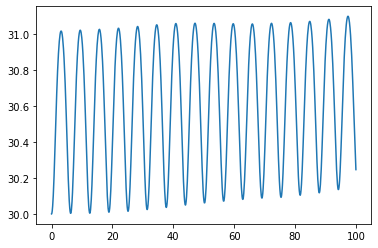

In [42]:
plt.plot(t, the1, label=f'$X_{0}(t)$')

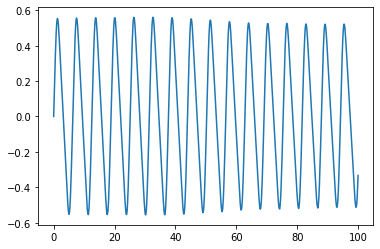

In [43]:
plt.plot(t, the1d, label=f'$X_{1}(t)$')

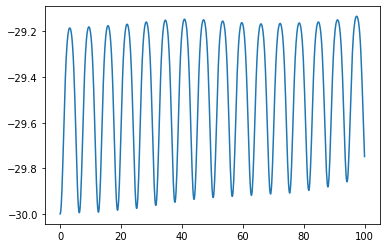

In [44]:
plt.plot(t, the2, label=f'$X_{2}(t)$')

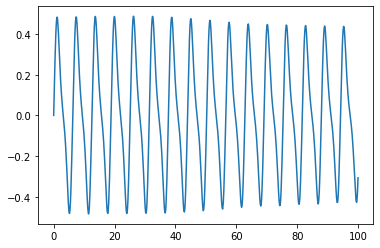

In [45]:
plt.plot(t, the2d, label=f'$X_{3}(t)$')